In [1]:
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme="onedork", context="notebook", ticks=True, grid=True)

import numpy as np
import itertools
import h5py
import os
import sys
import glob

import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import pandas as pd
import tikzplotlib

# from tqdm import tqdm
from tqdm.notebook import tqdm_notebook as tqdm

import helper.circular

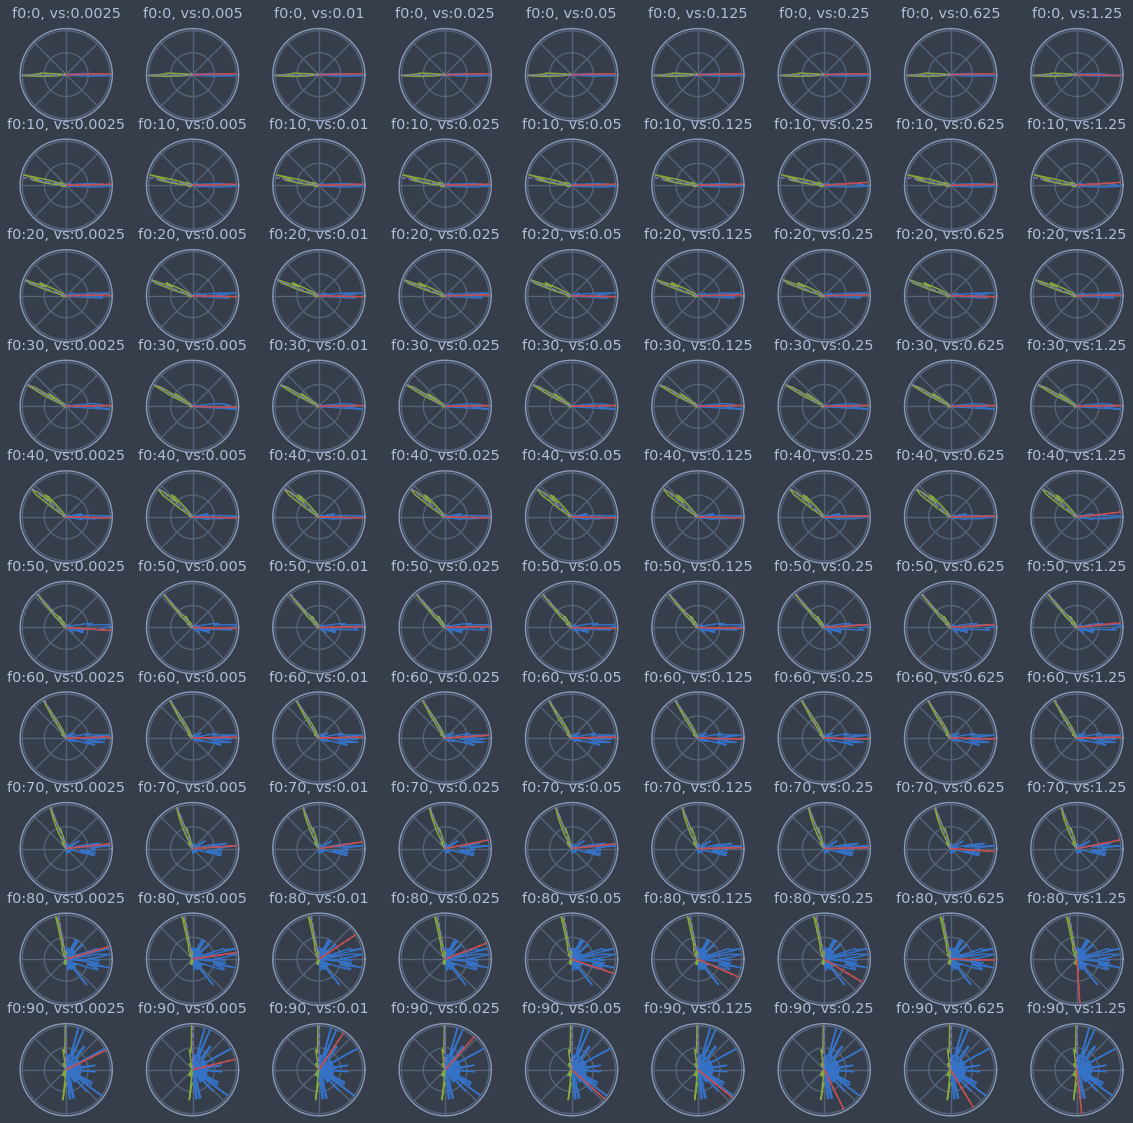

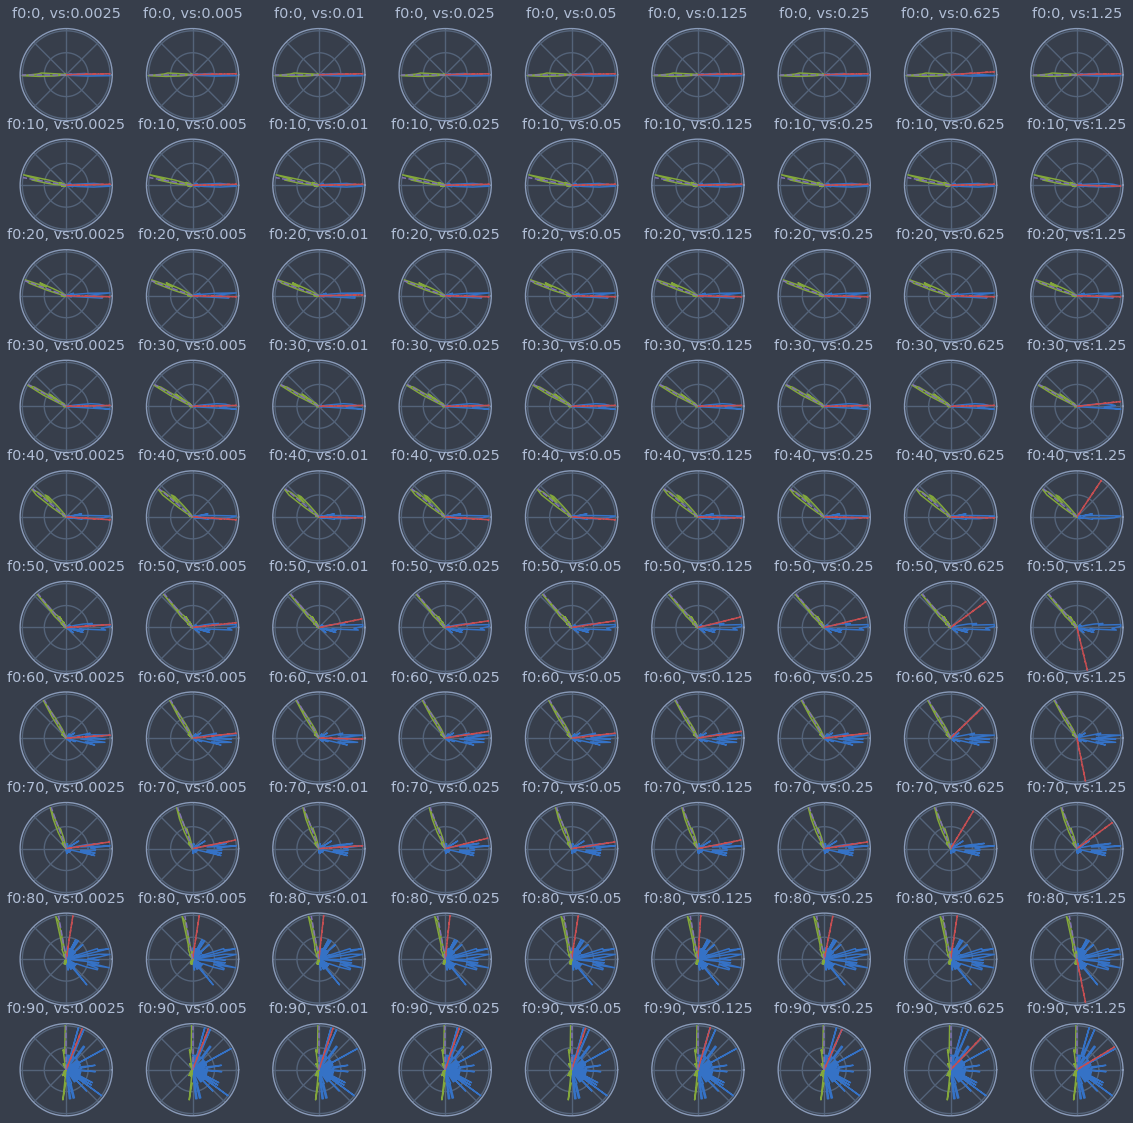

In [11]:
# hist_bin = lambda n: np.linspace(0, np.pi, n + 1, endpoint=True)

df = pd.read_pickle(os.path.join("output/vs_0/voxel_size_simulation.pkl"))

for model in df.model.unique():

    fig, axs = plt.subplots(len(df.f0_inc.unique()),
                            len(df.voxel_size.unique()),
                            subplot_kw={'projection': 'polar'},
                            figsize=(20, 20))
    axs = np.atleast_2d(axs)

    for i, f0_inc in enumerate(sorted(df.f0_inc.unique())):
        for j, vs in enumerate(sorted(df.voxel_size.unique())):
            axs[i, j].set_xticklabels([])
            axs[i, j].set_yticklabels([])
            axs[i, j].set_title(f"f0:{f0_inc:.0f}, vs:{vs}")

    for i, f0_inc in enumerate(sorted(df.f0_inc.unique())):
        for j, vs in enumerate(sorted(df.voxel_size.unique())):

            sub = (df.omega == 0.0) & (df.psi == 1.0) & (df.f1_rot == 0.0) & (
                df.voxel_size == vs) & (df.f0_inc == f0_inc) & (df.model
                                                                == model)

            df_sub = df[sub]

            if len(df_sub) > 1:
                print("fooo", omega, psi)
            if len(df_sub) == 0:
                continue

            phi = df_sub.explode("f_phi").f_phi.to_numpy(float)
            theta = df_sub.explode("f_theta").f_theta.to_numpy(float)
            phi, phi_inc = helper.circular.orientation_sph_plot(phi, theta)
            
            h, x = np.histogram(phi,
                                np.linspace(-np.pi / 2,
                                            np.pi / 2,
                                            4 * 18 + 1,
                                            endpoint=True),
                                density=True)
            x = x[:-1] + (x[1] - x[0]) / 2
            h = h / np.amax(h)
            axs[i, j].plot(x, h)

            h, x = np.histogram(phi_inc,
                                np.linspace(np.pi / 2,
                                            3 * np.pi / 2,
                                            4 * 18 + 1,
                                            endpoint=True),
                                density=True)
            x = x[:-1] + (x[1] - x[0]) / 2
            h = h / np.amax(h)
            axs[i, j].plot(x, h)

            phi = df_sub.explode("epa_dir").epa_dir.to_numpy(float)
            phi[phi > np.pi] -= 2 * np.pi
            phi[phi > np.pi / 2] -= np.pi
            h, x = np.histogram(phi,
                                np.linspace(-np.pi / 2,
                                            np.pi / 2,
                                            4 * 18 + 1,
                                            endpoint=True),
                                density=True)
            x = x[:-1] + (x[1] - x[0]) / 2
            h = h / np.amax(h)
            axs[i, j].plot(x, h, '--')
            axs[i,
                j].plot([np.deg2rad(180 - f0_inc),
                         np.deg2rad(180 - f0_inc)], [0, 1], '--')

In [ ]:
hist_bin = lambda n: np.linspace(0, np.pi, n + 1, endpoint=True)

df = pd.read_pickle(os.path.join("output/vs__2/voxel_size_simulation.pkl"))
# df = df[df.voxel_size >= 0.1]

for model in df.model.unique():

    fig, axs = plt.subplots(
        len(df.f0_inc.unique()),
        len(df.voxel_size.unique()),
        #                             subplot_kw={'projection': 'polar'},
        figsize=(20, 20))
    axs = np.atleast_2d(axs)

    for i, f0_inc in enumerate(sorted(df.f0_inc.unique())):
        for j, vs in enumerate(sorted(df.voxel_size.unique())):
            axs[i, j].set_ylim((9000, 16000))
            axs[i, j].set_title(f"f0:{f0_inc:.0f}, vs:{vs}")

    for i, f0_inc in enumerate(sorted(df.f0_inc.unique())):
        for j, vs in enumerate(sorted(df.voxel_size.unique())):
            sub = (df.omega == 0.0) & (df.psi == 1.0) & (df.f1_rot == 0.0) & (
                df.voxel_size == vs) & (df.f0_inc == f0_inc) & (df.model
                                                                == model)

            df_sub = df[sub]

            if len(df_sub) > 1:
                print("fooo", omega, psi)
            if len(df_sub) == 0:
                continue

            data = df_sub.iloc[0]['data']
            data.shape = (-1, data.shape[-1])
            x = np.linspace(0, 180, data.shape[-1], False)
            if data.shape[0] > 23:
                data = data[::data.shape[0] // 23, :]
            for d in range(data.shape[0]):
                axs[i, j].plot(x, data[d, :], 'g')
            axs[i, j].plot(x, df_sub.iloc[0]['optic'], 'r')

            data = df_sub.iloc[0]['data']
            data.shape = (-1, data.shape[-1])
            axs[i, j].plot(x, np.mean(data, axis=0), 'b')